In [68]:
import sys
import os
from pathlib import Path
import numpy as np
import cv2
import matplotlib.pyplot as plt

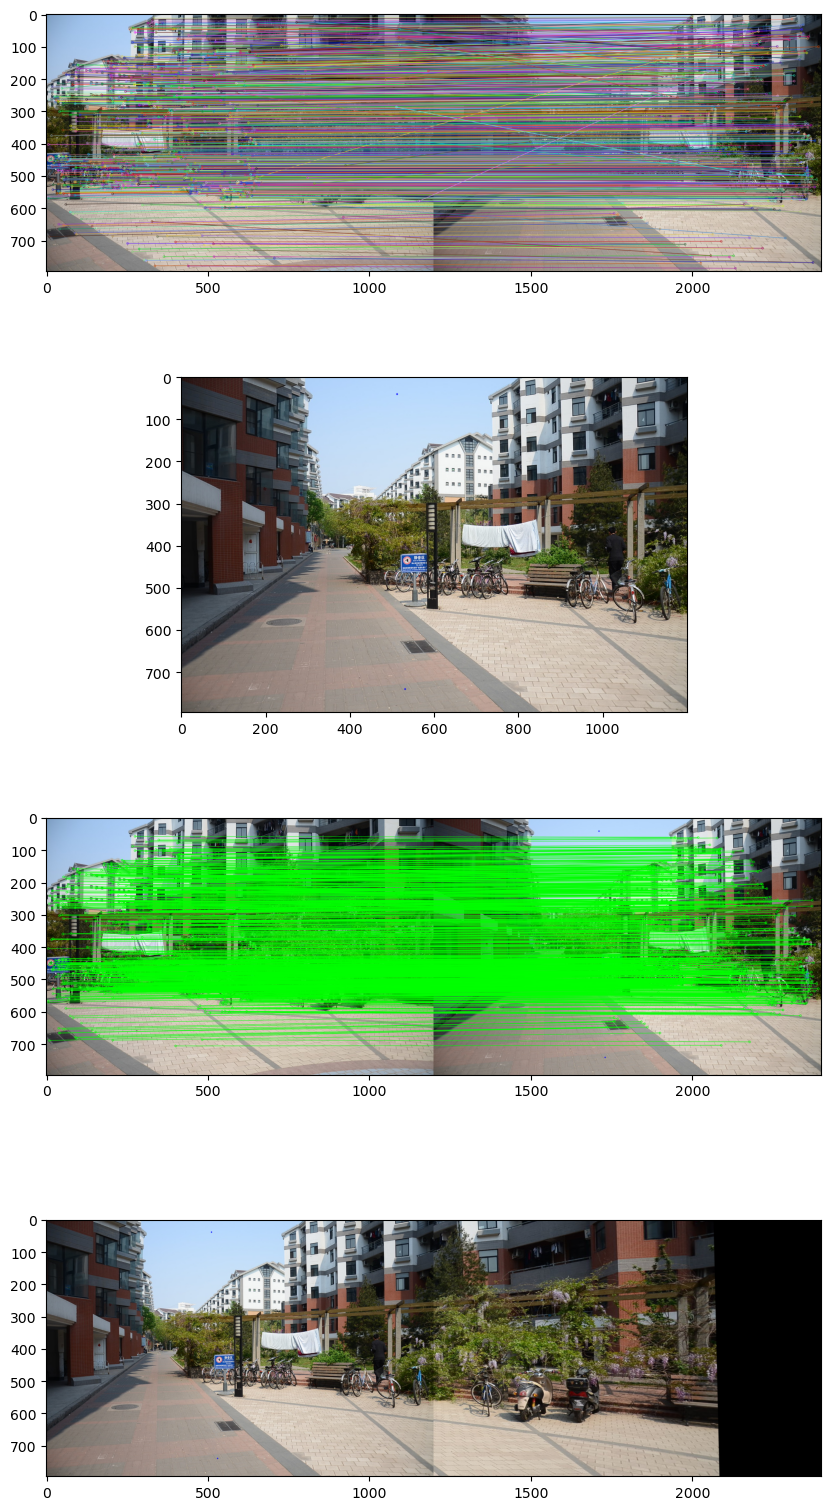

In [93]:
def main(data_folder: str | Path, mode: str = 'plot'):
    """
    Parameters
    ----------
    data_folder : str | Path
        Path to folder containing medium02 and medium03 images
    mode : {'plot', 'save', None}
        indicates if images should be displayed or saved in `data_folder`
        If saved name follows the format `output_{i}_*.png`
        if None does not save or plot images
    """
    if mode is not None:
        assert mode in ['plot', 'save']
        plt.figure(figsize=(10, 20))

    if isinstance(data_folder, Path):
        data_folder = str(data_folder)
    # img1 = cv2.imread(data_folder + '/data/medium02.jpg')
    # img2 = cv2.imread(data_folder + '/data/medium03.jpg')
    img1 = cv2.imread(data_folder + '/data/medium03.jpg')
    img2 = cv2.imread(data_folder + '/data/medium02.jpg')

    # Open images and detect keypoints
    gray = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
    sift = cv2.xfeatures2d.SIFT_create()
    kp1, des1 = sift.detectAndCompute(gray, None) # len 3655, des1.shape 3655, 128
    gray = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)
    kp2, des2 = sift.detectAndCompute(gray, None) # len 5618
    
    # match keypoints
    matcher = cv2.BFMatcher()
    matches = matcher.knnMatch(des1, des2, k=2)

    # filter matches
    good_matches = []
    for m, n in matches:
        if m.distance < 0.75 * n.distance:
            good_matches.append(m)
        
    # draw matches
    img3 = cv2.drawMatches(img1, kp1, img2, kp2, good_matches, None, flags=2)
    if mode == 'plot':
        plt.subplot(411)
        plt.imshow(img3[:,:,::-1])
    elif mode == 'save':
        cv2.imwrite(data_folder + '/data/output_1_matches.jpg', img3)

    # find homography
    MIN_MATCH_COUNT = 10
    if len(good_matches) <= MIN_MATCH_COUNT:
        raise Exception('Not enough matches are found - {}/{}'.format(len(good_matches), MIN_MATCH_COUNT))
    kp1_np = np.float32([x.pt for x in kp1])
    kp2_np = np.float32([x.pt for x in kp2])
    src_pts = np.float32([kp1_np[m.queryIdx] for m in good_matches])
    dst_pts = np.float32([kp2_np[m.trainIdx] for m in good_matches])
    reproj_thresh = 4.0 # RANSAC reprojection error threshold
    # TODO: set method=0 instead of cv2.RANSAC when using CUDA RANSAC
    M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, reproj_thresh)
    mask = mask[:,0]
    h, w, d = img1.shape
    pts = np.float32([[0, 0], [0, h-1], [w-1, h-1], [w-1, 0]]).reshape(-1, 1, 2)
    dst = cv2.perspectiveTransform(pts, M).astype(np.int32)
    img2 = cv2.polylines(img2, dst, True, 255, 3, cv2.LINE_AA)
    if mode == 'plot':
        plt.subplot(412)
        plt.imshow(img2[:,:,::-1])
    elif mode == 'save':
        cv2.imwrite(data_folder + '/data/output_2_stitched.jpg', img2)

    # draw matches
    draw_params = dict(matchColor=(0, 255, 0), singlePointColor=None, matchesMask=mask, flags=2)
    img3 = cv2.drawMatches(img1, kp1, img2, kp2, good_matches, None, **draw_params)
    if mode == 'plot':
        plt.subplot(413)
        plt.imshow(img3[:,:,::-1])
    elif mode == 'save':
        cv2.imwrite(data_folder + '/data/output_3_matches.jpg', img3)

    # stitch images
    dst = cv2.warpPerspective(img1, M, (img1.shape[1] + img2.shape[1], img1.shape[0]))
    dst[0:img1.shape[0], 0:img1.shape[1]] = img2
    if mode == 'plot':
        plt.subplot(414)
        plt.imshow(dst[:,:,::-1])
    elif mode == 'save':
        cv2.imwrite(data_folder + '/data/output_4_stitched.jpg', dst)

    # # stitch images with opencv
    # stitcher = cv2.Stitcher.create()
    # result = stitcher.stitch((img1, img2))
    # # cv2.imwrite(PATH + '/data/stitched_opencv.jpg', result[1])
    # plt.imshow(result[1][:,:,::-1])
    # plt.show()

    

main('./', mode='plot')

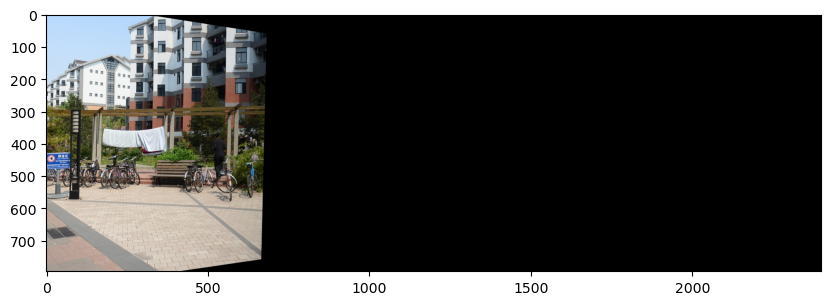

In [88]:
plt.figure(figsize=(10, 20))
dst = cv2.warpPerspective(img1, M, (img1.shape[1] + img2.shape[1], img1.shape[0]))
# dst[0:img1.shape[0], 0:img1.shape[1]] = img1
plt.imshow(dst[:,:,::-1])

(4, 1, 2) (4, 1, 2) int32


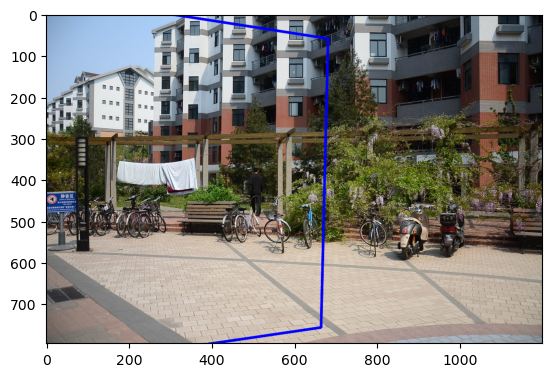

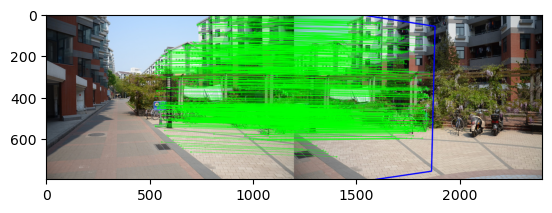

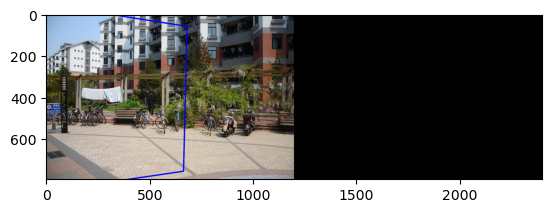

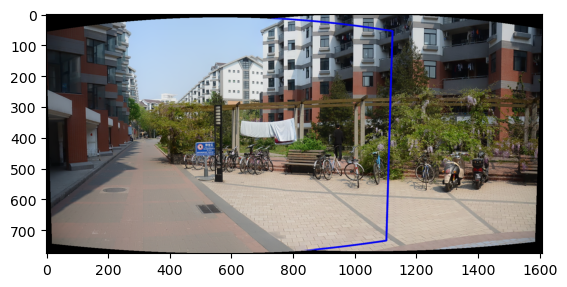